# Previous attempts

## Attempt 1

We are solving the following system of equations:
$$\frac{\Omega_i^k - \Omega^{k-1}_i}{\tau} - \frac{v^{k-1}\xi_i}{\gamma^{k-1}} \frac{\Omega_{i+1}^k - \Omega^{k}_{i-1}}{2h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3(\Omega_{i+1}^k - \Omega^{k}_{i})  - \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 (\Omega_{i}^k - \Omega^{k}_{i-1})\right) = 0$$

$$\Omega_0^k = 0$$
$$\Omega_{N-1}^k = 1$$

$$  v^k = (\Omega_{N-2}^k)^2 \frac{ \Omega_{N-3}^k}{2\gamma^{k-1} h}   $$

Let's combine the terms

$$ \Omega_{i+1}^k \left( - \frac{v^{k-1}\xi_i}{2\gamma^{k-1} h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3 \right)  + \Omega_i^k \left( \frac{1}{\tau} +  \frac{1}{(\gamma^{k-1} h)^2}\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3 - \frac{1}{(\gamma^{k-1} h)^2}\left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 \right) + \Omega_{i-1}^k \left( \frac{v^{k-1}\xi_i}{2\gamma^{k-1} h} -  \frac{1}{(\gamma^{k-1} h)^2} \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 \right) = \frac{\Omega_i^{k-1}}{\tau}$$

So we'll need to solve the system of equations

$$ A(\Omega^{k-1}) \Omega^k = f(\Omega^{k-1})$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [98]:
N = 100
xi = np.linspace(0,1,N)
h = 1/(N-1)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
g = 4                             # initial gamma
v0 = W0[N-2]**2*W0[N-3]/g/2/h     # initial velocity
t = 10**(-5)                      # time step

Text(0, 0.5, 'xi')

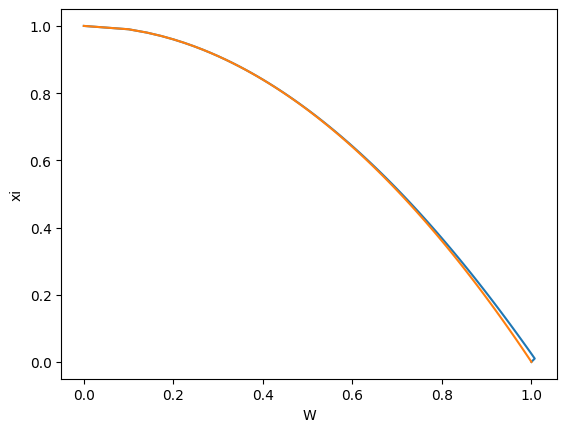

In [99]:
v_prev = v0.copy()
W_prev = W0.copy()
eps = 1
eps_v = 1

n_t = 10**5        # number of time steps
# psi0 = np.empty(n_t+1)
# psi0[0] = - ((W0[0] + W0[1])/2)**3/g*(-W0[0] + W0[1])/h
# t0 = 10**(-3)
# time = [t0]

for j in range(n_t):                # time loop
    # gs.append(g)
    # ts.append(j*t)
    while(eps_v > 10**(-2)):        # loop to approximate the velocity v
        while(eps > 10**(-2)):      # loop to approximate the opening omega
            # upper diagonal
            a1 = np.zeros(N-1)
            a1[1:-1] = - v_prev/g*xi[1:-2]/2/h - 1/(g*h)**2*((W_prev[1:-2] + W_prev[2:-1])/2)**3

            # main diagonal
            a0 = np.ones(N)
            a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3

            # lower diagonal
            a_1 = np.zeros(N-1)
            a_1[:-1] = v_prev/g*xi[1:-1]/2/h - 1/(g*h)**2*((W_prev[:-2] + W_prev[1:-1])/2)**3

            # right hand side
            f = np.zeros(N)
            f[0] = 1
            f[-1] = 0
            f[1:-1] = W_prev[1:-1]/t

            # making matrix and solving the system
            k = [a_1,a0, a1]
            offset = [-1,0,1]
            A = diags(k,offset, format = 'csr')
            W = spsolve(A, f)

            # error of solution
            eps = np.sqrt(((W - W_prev)**2).mean())
            
            W_prev = W.copy()

        # getting new velocity
        v = W_prev[N-2]**2*W_prev[N-3]/g/2/h
        eps_v = np.abs(v - v_prev)
        v_prev = v.copy()

    # getting new gamma
    g = g + v_prev*t
    # time.append(time[j] + t)
    # psi0[j+1] = - ((W[0] + W[1])/2)**3/g*(-W[0] + W[1])/h

plt.figure()
plt.plot(W_prev, xi)
plt.plot(W0, xi)
plt.xlabel('W')
plt.ylabel('xi')

## Attempt 1.1

In [319]:
N = 10
xi = np.linspace(0,1,N)
h = 1/(N-1)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
g = 4                             # initial gamma
v0 = W0[N-2]**2*W0[N-3]/g/2/h     # initial velocity
t = 10**(-7)                      # time step

[ 0.         -8.78063418 -6.81093147 -5.09107666 -3.62100476 -2.40059926
 -1.4296195  -0.7074292  -0.22980474  0.        ]
[ 0.00000000e+00 -1.57949663e+03 -5.53812909e+04 -2.05935912e+04
 -6.71276235e+03 -1.84456604e+03 -4.02496605e+02 -6.30515414e+01
 -5.69382229e+00  0.00000000e+00]
[ 0.00000000e+00 -6.29769985e+18  2.99000276e+18 -2.09201383e+19
 -3.50421380e+17 -3.39471808e+15 -1.62578158e+13 -3.05350048e+10
 -1.56204073e+07  0.00000000e+00]
[ 0.00000000e+00 -7.82715424e+74 -8.72941074e+76  5.98632348e+76
 -1.29536061e+77 -9.91711619e+69 -8.56622846e+61 -4.45434149e+52
 -5.51258711e+41  0.00000000e+00]
[ 0.00000000e+000 -3.74053111e+307 -3.61600637e+307 -4.08945511e+307
  1.63259593e+308 -1.78171376e+308 -6.12091954e+279 -3.40748271e+247
 -2.49120280e+210  0.00000000e+000]
[  0.  nan  nan -inf  nan  nan  nan  nan  nan   0.]


C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:50: RuntimeWarning: overflow encountered in square
  eps = np.sqrt(((W - W_prev)**2).mean())
C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:25: RuntimeWarning: overflow encountered in power
  a1[1:-1] = - v_prev/g*xi[1:-2]/2/h - 1/(g*h)**2*((W_prev[1:-2] + W_prev[2:-1])/2)**3
C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:28: RuntimeWarning: overflow encountered in power
  a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3
C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:28: RuntimeWarning: invalid value encountered in subtract
  a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3
C:\Users\User\AppData\Local\Temp\ipykernel_4476\3212063572.py:31: RuntimeWarning: overflow encountered in power
  a_1[:-1] = v_prev/g*xi[1:-1]/2/h - 1/(g*h)**2*((W_prev[:-2] + W_

Text(0, 0.5, 'xi')

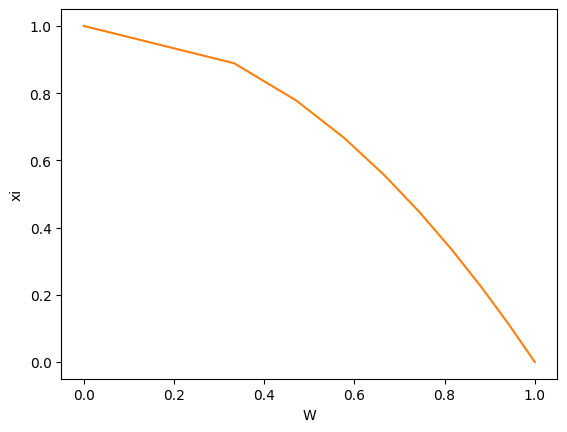

In [326]:
v_prev = v0.copy()
W_prev = W0.copy()
eps = 1
eps_v = 1
errs = []

n_t = 10**5        # number of time steps
# psi0 = np.empty(n_t+1)
# psi0[0] = - ((W0[0] + W0[1])/2)**3/g*(-W0[0] + W0[1])/h
# t0 = 10**(-3)
# time = [t0]

# for j in range(n_t):                # time loop
    # gs.append(g)
    # ts.append(j*t)
    # while(eps_v > 10**(-2)):        # loop to approximate the velocity v
        # while(eps > 10**(-2)):      # loop to approximate the opening omega
            # upper diagonal
i = 0
max_iter = 100
while eps > 10**(-2):
    # print(i)
    i += 1
    a1 = np.zeros(N-1)
    a1[1:-1] = - v_prev/g*xi[1:-2]/2/h - 1/(g*h)**2*((W_prev[1:-2] + W_prev[2:-1])/2)**3
    # main diagonal
    a0 = np.ones(N)
    a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3
    # lower diagonal
    a_1 = np.zeros(N-1)
    a_1[:-1] = v_prev/g*xi[1:-1]/2/h - 1/(g*h)**2*((W_prev[:-2] + W_prev[1:-1])/2)**3
    # right hand side
    f = np.zeros(N)
    f[0] = 1
    f[-1] = 0
    f[1:-1] = W_prev[1:-1]/t
    
    # making matrix and solving the system
    k = [a_1,a0, a1]
    offset = [-1,0,1]
    A = diags(k,offset, format = 'csr')
    # if i == 1:
        # W = spsolve(A, f)
    # else:
        # W = W_prev - A@W_prev + f
    # error of solution
    # eps = np.sqrt(((W - W_prev)**2).mean())
    # A_inv = np.linalg.inv(A)
    W = W_prev -  A@W_prev + f
    eps = np.sqrt(((W - W_prev)**2).mean())
    errs.append(eps)
    print(A@W_prev - f)
    W_prev = W.copy()
    if i == max_iter:
        break

# print(A@W_prev - f)
# print(A@W - f)
    
# W_prev = W.copy()
# # getting new velocity
# v = W_prev[N-2]**2*W_prev[N-3]/g/2/h
# eps_v = np.abs(v - v_prev)
# v_prev = v.copy()

    # getting new gamma
    # g = g + v_prev*t
    # time.append(time[j] + t)
    # psi0[j+1] = - ((W[0] + W[1])/2)**3/g*(-W[0] + W[1])/h

plt.figure()
plt.plot(W_prev, xi)
plt.plot(W0, xi)
plt.xlabel('W')
plt.ylabel('xi')

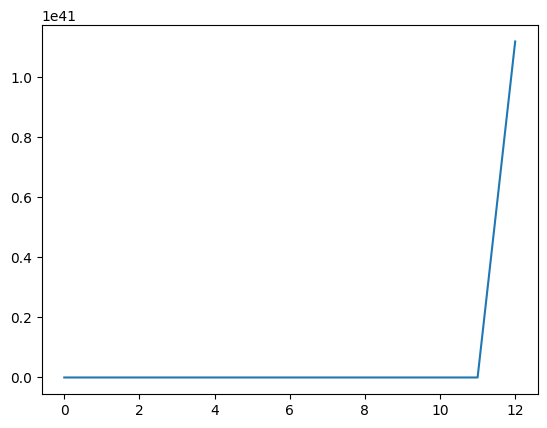

In [324]:
plt.plot(errs)

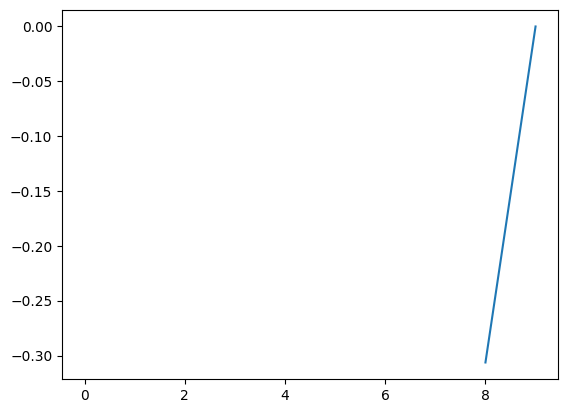

In [325]:
plt.plot(W - W0)

## Attempt 2
We are solving the following system of equations:
$$\frac{\Omega_i^k - \Omega^{k-1}_i}{\tau} - \frac{v^{k-1}\xi_i}{\gamma^{k-1}} \frac{\Omega_{i+1}^k - \Omega^{k}_{i-1}}{2h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3(\Omega_{i+1}^k - \Omega^{k}_{i})  - \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 (\Omega_{i}^k - \Omega^{k}_{i-1})\right) = 0$$

$$\Omega_{-1}^k = 0$$
$$\Omega_{N}^k = 1$$

$$ v^k = (\Omega_{N-1}^k)^2 \frac{ \Omega_{N-2}^k}{2\gamma^{k-1} h}  $$

Let's introduce new variable $\Delta \Omega_i = \Omega_i^k -  \Omega_i^{k-1} $ and rewrite equations. Let $\Omega_i^0 = \Omega_i^{k-1}$.

$$ \Delta \Omega_i - \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Delta \Omega_{i+1} - \Delta \Omega_{i-1}) - \frac{\tau}{(\gamma^{k-1} h)^2} \left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Delta\Omega_{i+1} -\Delta \Omega_{i}) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Delta\Omega_{i} - \Delta\Omega_{i-1})  \right) =  \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Omega_{i+1}^0 - \Omega_{i-1}^0) + \frac{\tau}{(\gamma^{k-1} h)^2}\left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Omega_{i+1}^0 - \Omega_{i}^0) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Omega_{i}^0 - \Omega_{i-1}^0) \right)$$

Let's combine the terms

$$ \Delta \Omega_{i+1} \left( - \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} - \frac{\tau}{(\gamma^{k-1} h)^2} \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 \right)  + \Delta \Omega_i \left( 1 +  \frac{\tau}{(\gamma^{k-1} h)^2}\left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 - \frac{\tau}{(\gamma^{k-1} h)^2}\left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 \right) + \Delta \Omega_{i-1} \left( \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} -  \frac{1}{(\gamma^{k-1} h)^2} \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 \right) = \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Omega_{i+1}^0 - \Omega_{i-1}^0) + \frac{\tau}{(\gamma^{k-1} h)^2}\left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Omega_{i+1}^0 - \Omega_{i}^0) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Omega_{i}^0 - \Omega_{i-1}^0) \right)$$

So we'll need to solve the system of equations

$$ A(\Omega^0) \Delta \Omega = f(\Omega^0)$$

In [331]:
# k_{i+1/2} = ((omega(i+1) + omega(i))/2)^3
def K(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    return k**3

# psi_{k+1/2}
# def psi(w, g):
#     psi = np.empty(w.shape[0] + 1)
#     k = K(w)
#     psi[0] = - k[0]*(w[0] - 1)/(h*g)
#     psi[-1] = - k[-1]*w[-1]/(h*g)
#     psi[1:-1] = - k[1:-1]*(w[2:] - w[1:-1])/(h*g)
#     return psi

In [334]:
N = 10
h = 1/(N+1)
xi = np.linspace(h, 1 - h, N)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
tau = 10**(-4)                    # time step
g = 4                             # initial gamma
v0 = W0[-1]**2*W0[-2]/g/2/h       # initial velocity

# useful coeffitients
a = tau/(g*h)**2
b = tau*v0/(2*g*h)

W_prev = W0.copy()

errs = []
err = 1

# for j in range(nt)            # time loop
for i in range(1000):         # solving nonlinear equation for given time step

    # making matrix A
    
    k = K(W_prev)

    k0 = 1 + a*(k[1:] - k[:-1])
    k1 = -b*xi[:-1] - a*k[1:-1]
    k_1 = b*xi[1:] - a*k[1:-1]

    A = diags([k_1, k0, k1],[-1,0,1], format = 'csr')

    # right-hand side
    
    f = np.empty(N)
    f[0] = b*xi[0]*(W_prev[1] - 1) + a*(k[1]*(W_prev[1] - W0[0]) - k[0]*(W_prev[0] - 1))
    f[1:-1] = b*xi[1:-1]*(W_prev[2:] - W_prev[:-2]) + a*(k[2:-1]*(W_prev[2:] - W_prev[1:-1]) - k[1:-2]*(W_prev[1:-1] - W_prev[:-2]))
    f[-1] = b*xi[-1]*(-W_prev[-1]) + a*(k[-1]*(-W_prev[-1]) - k[-2]*(W_prev[-1] - W_prev[-2]))

    # solving system
    dW = spsolve(A, f)

    # new solution
    W_next = W_prev + dW

    err = np.sqrt(((W_next - W_prev)**2).mean())
    errs.append(err)

    if err > 1:
        print('error: ', err)
        break

    W_prev = W_next.copy()

# print('a: ', a)
# print('b: ', b)

[1.         0.95633607 0.90750641 0.85572849 0.80056378 0.74128362
 0.67680703 0.60546808 0.52445712 0.42828503 0.30329581 0.        ]


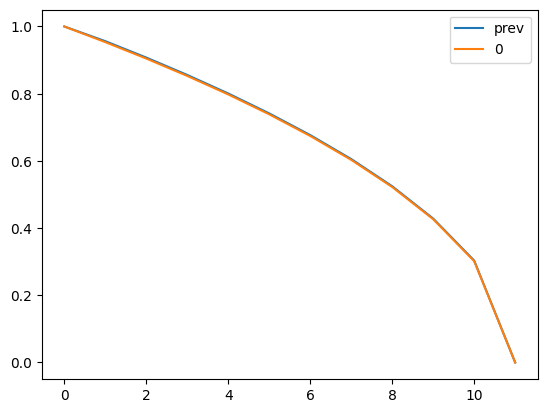

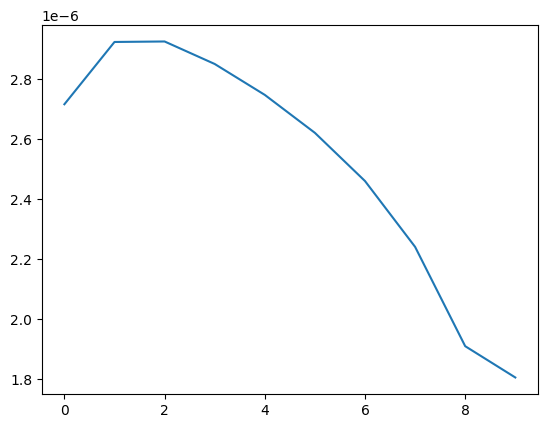

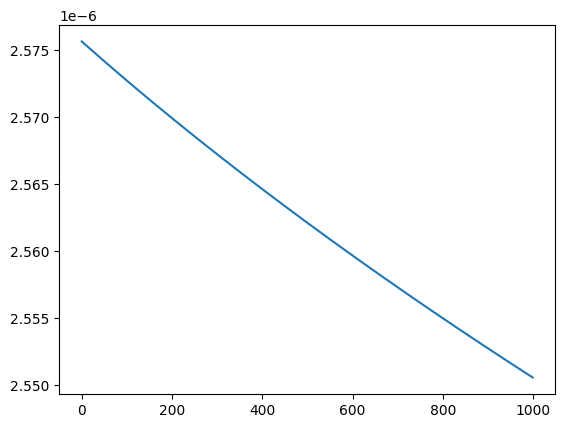

In [335]:
u1 = np.ones(1)
u1 = np.append(u1, W_prev)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
print(u1)

plt.plot(u1, label = 'prev')
plt.plot(u0, label = '0')
plt.legend()
plt.figure()
plt.plot(dW)
plt.figure()
plt.plot(errs)

## Attempt 2.1
simple iteration

In [339]:
def K(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    return k**3

In [340]:
N = 1000
h = 1/(N+1)
xi = np.linspace(h, 1 - h, N)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
tau = 10**(-5)                    # time step
g = 4                             # initial gamma
v0 = W0[-1]**2*W0[-2]/g/2/h       # initial velocity

# useful coeffitients
a = tau/(g*h)**2
b = tau*v0/(2*g*h)

W_prev = W0.copy()

errs = []
err = 1

dW_prev = np.zeros(N)
# for j in range(nt)            # time loop

steps = 0
max_iter = 1000
while err > 10**(-8):         # solving nonlinear equation for given time step

    # making matrix A
    
    k = K(W_prev)

    k0 = 1 + a*(k[1:] - k[:-1])
    k1 = -b*xi[:-1] - a*k[1:-1]
    k_1 = b*xi[1:] - a*k[1:-1]

    A = diags([k_1, k0, k1],[-1,0,1], format = 'csr')

    # right-hand side
    
    f = np.empty(N)
    f[0] = b*xi[0]*(W_prev[1] - 1) + a*(k[1]*(W_prev[1] - W0[0]) - k[0]*(W_prev[0] - 1))
    f[1:-1] = b*xi[1:-1]*(W_prev[2:] - W_prev[:-2]) + a*(k[2:-1]*(W_prev[2:] - W_prev[1:-1]) - k[1:-2]*(W_prev[1:-1] - W_prev[:-2]))
    f[-1] = b*xi[-1]*(-W_prev[-2]) + a*(k[-1]*(-W_prev[-1]) - k[-2]*(W_prev[-1] - W_prev[-2]))

    # solving system
    # dW = spsolve(A, f)

    dW = dW_prev - A@dW_prev + f
    
    # new solution
    # W_next = W_prev + dW

    err = np.sqrt(((dW - dW_prev)**2).mean())
    errs.append(err)

    if err > 1:
        break

    # W_prev = W_next.copy()
    dW_prev = dW.copy()

    steps += 1
    if steps == max_iter:
        break

W_prev = W0 + dW
print(steps, err)

84 1.062377357107137


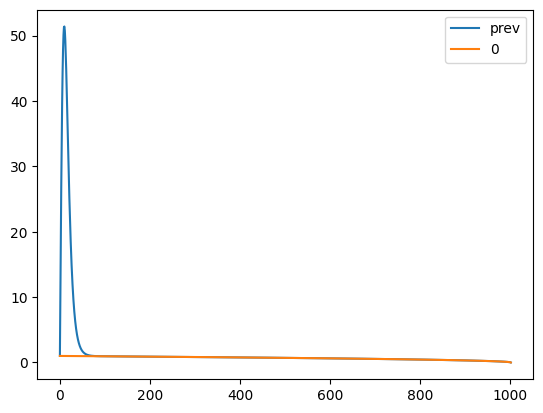

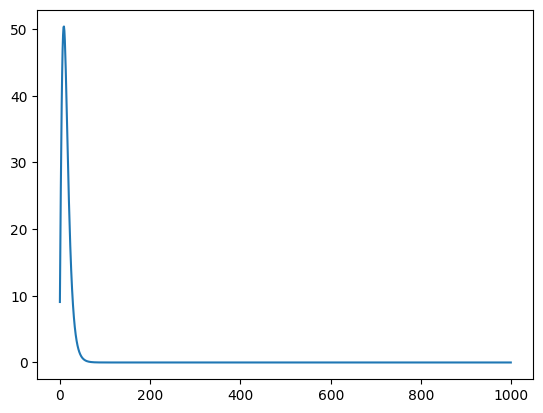

In [341]:
u1 = np.ones(1)
u1 = np.append(u1, W_prev)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
# print(u1)

plt.plot(u1, label = 'prev')
plt.plot(u0, label = '0')
plt.legend()
plt.figure()
plt.plot(dW)

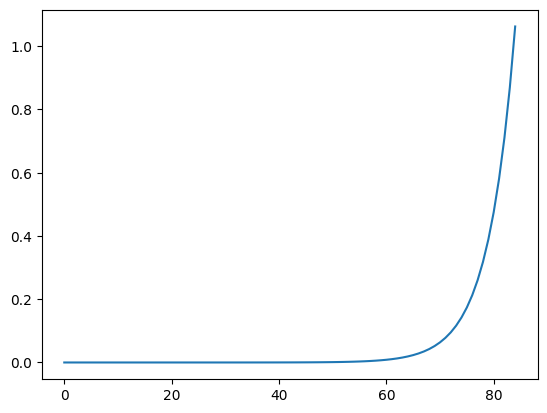

In [342]:
plt.plot(errs)

## Attempt 2.2
Newton method

In [336]:
N = 10
h = 1/(N+1)
xi = np.linspace(h, 1 - h, N)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
tau = 10**(-8)                    # time step
g = 0.1                           # initial gamma
v0 = W0[-1]**2*W0[-2]/g/2/h       # initial velocity

# useful coeffitients
a = tau/(g*h)**2
b = tau*v0/(2*g*h)

W_prev = W0.copy()
W1 = W0.copy()

errs = []
err = 1

dW_prev = np.zeros(N)
# for j in range(nt)            # time loop

steps = 0
max_iter = 1000
while err > 10**(-8):         # solving nonlinear equation for given time step

    # making matrix A
    
    k = K(W_prev)

    k0 = 1 + a*(k[1:] - k[:-1])
    k1 = -b*xi[:-1] - a*k[1:-1]
    k_1 = b*xi[1:] - a*k[1:-1]

    A = diags([k_1, k0, k1],[-1,0,1]).toarray()

    # right-hand side
    
    f = np.empty(N)
    f[0] = b*xi[0]*(W_prev[1] - 1) + a*(k[1]*(W_prev[1] - W0[0]) - k[0]*(W_prev[0] - 1))
    f[1:-1] = b*xi[1:-1]*(W_prev[2:] - W_prev[:-2]) + a*(k[2:-1]*(W_prev[2:] - W_prev[1:-1]) - k[1:-2]*(W_prev[1:-1] - W_prev[:-2]))
    f[-1] = b*xi[-1]*(-W_prev[-2]) + a*(k[-1]*(-W_prev[-1]) - k[-2]*(W_prev[-1] - W_prev[-2]))

    # solving system
    # dW = spsolve(A, f)
    # print(A.shape)
    # print(A)
    A_inv = np.linalg.inv(A)

    dW = dW_prev - A_inv @ ( A@dW_prev - f)
    
    # print(A@dW_prev - f)
    # new solution
    
    # W_next = W1 + dW
    # print(dW, dW_prev)
    err = np.sqrt(((dW - dW_prev)**2).mean())
    errs.append(err)

    if err > 1:
        break

    # W1 = W_next.copy()
    dW_prev = dW.copy()

    steps += 1
    if steps == max_iter:
        break

W_prev = W0 + dW
print(steps, err)

2 5.799238152015798e-23


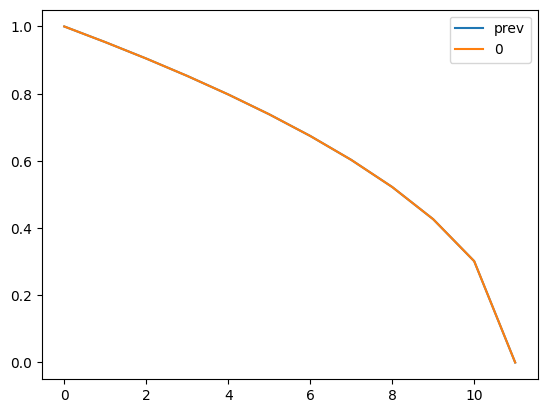

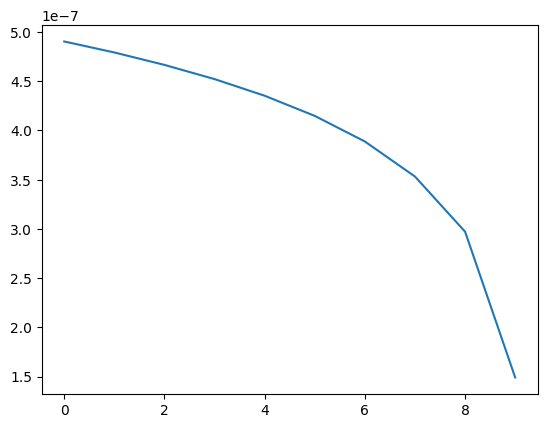

In [337]:
u1 = np.ones(1)
u1 = np.append(u1, W_prev)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
# print(u1)

plt.plot(u1, label = 'prev')
plt.plot(u0, label = '0')
plt.legend()
plt.figure()
plt.plot(dW)

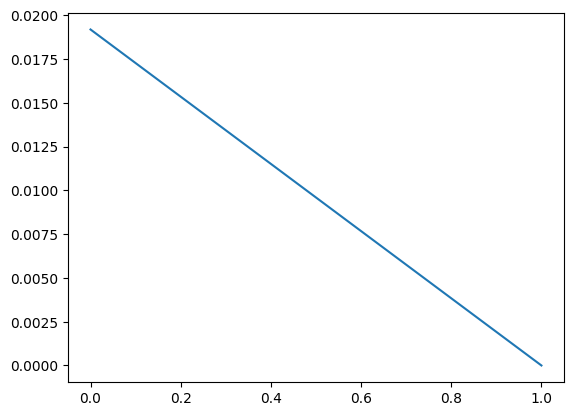

In [264]:
plt.plot(errs)

# Attempt 2.3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from numba import njit
import time
from mpmath import *
from scipy.special import gegenbauer
from scipy.integrate import simpson
import pickle 

### functions

In [2]:
def analyt_sol(time, ksi):
        a_coef = np.array([0.73658, 3.22225e-2, 0.28157e-2, 0.20421e-2, 0.79333e-3, 0.58367e-3,
                           0.27394e-3, 0.17645e-3, 0.64422e-4, 0.33006e-4]).astype(np.float64)
        b_coef = 0.28924
        gamma_coef = 0.86998

        vel = gamma_coef * 0.5 / time ** 0.5

        l = gamma_coef * time ** 0.5

        p_coef = [gegenbauer(2 * i - 2, 5 / 6) for i in range(1, 11)]

        w = b_coef * (1 - ksi)

        for i in range(10):
            w += a_coef[i] * p_coef[i](ksi) * (1 - ksi ** 2) ** (1 / 3)

        Q_0 = 1 / l * simpson(y=w, x=ksi) * gamma_coef ** 2 / 2

        return l, w, vel, Q_0

In [3]:
@njit
def calc_psi_B_jit(w, g, h, sgnB):
    psi0 = - ((w[0] + 1)/2)**3/g*((w[0] - 1)/h[0] - g*sgnB)
    return psi0

@njit
def K_jit(w, T):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = (T + w[-1])/2
    k[1:-1] = (w[:-1] + w[1:])/2
    if np.any(k < 0):
        return np.zeros(w.shape[0] + 1)
    return np.power(k,3)

@njit
def dK_jit(w, k):
    dk = 3/2*np.power(k,2/3)
    return dk

@njit
def make_A_jit(w, xi, h, k, a, b):
    A = (np.diag(1 + b/(h[1:] + h[:-1])*(k[1:]/h[1:] + k[:-1]/h[:-1])) + 
         np.diag(-a/(h[1:-1] + h[:-2])*xi[:-1] - b*k[1:-1]/(h[1:-1] + h[:-2])/h[1:-1], 1) + 
         np.diag(a/(h[1:-1] + h[2:])*xi[1:] - b*k[1:-1]/(h[1:-1] + h[2:])/h[1:-1], -1))
    return A

@njit
def make_f_B_jit(w, xi, h, k, a, b, c, T):
    f = np.empty_like(w)
    f[0] = (a*xi[0]*(w[1] - 1)/(h[0] + h[1]) + 
            b*(k[1]*(w[1] - w[0])/h[1] - k[0]*(w[0] - 1)/h[0])/(h[0] + h[1]) + 
            c*(k[0] - k[1])/(h[0] + h[1]))
    f[1:-1] = (a*xi[1:-1]*(w[2:] - w[:-2])/(h[1:-2] + h[2:-1]) + 
               b/(h[1:-2] + h[2:-1])*(k[2:-1]*(w[2:] - w[1:-1])/h[2:-1] - k[1:-2]*(w[1:-1] - w[:-2])/h[1:-2]) + 
               c*(k[1:-2] - k[2:-1])/(h[1:-2] + h[2:-1]))
    f[-1] = (a*xi[-1]*(T - w[-2])/(h[-1] + h[-2]) + 
             b/(h[-1] + h[-2])*(k[-1]*(T - w[-1])/h[-1] - k[-2]*(w[-1] - w[-2])/h[-2]) + 
             c*(k[-2] - k[-1])/(h[-1] + h[-2]))
    return f

@njit
def make_F_B_jit(A, w, dw, xi, h, k, a, b, c, T):
    dk = dK_jit(w, k)
    # main diagonal
    F0 = np.empty_like(w)
    F0[0] = (A[0,0] + dw[0]*b/(h[0] + h[1])*(dk[1]/h[1] + dk[0]/h[0]) - 
             dw[1]*b/(h[0] + h[1])*dk[1]/h[1] - 
             b/(h[0] + h[1])*(dk[1]*(w[1] - w[0])/h[1] - dk[0]*(w[0] - 1)/h[0]) - 
             c/(h[0] + h[1])*(dk[0] - dk[1]))
    F0[1:-1] = (np.diag(A)[1:-1] - dw[2:]*b/(h[2:-1] + h[1:-2])*dk[2:-1]/h[2:-1] + 
                dw[1:-1]*b/(h[2:-1] + h[1:-2])*(dk[2:-1]/h[2:-1] + dk[1:-2]/h[1:-2]) - 
                dw[:-2]*b/(h[2:-1] + h[1:-2])*dk[1:-2]/h[1:-2] - 
                b/(h[2:-1] + h[1:-2])*(dk[2:-1]/h[2:-1]*(w[2:] - w[1:-1]) - 
                                       dk[1:-2]/h[1:-2]*(w[1:-1] - w[:-2])) - 
                c/(h[2:-1] + h[1:-2])*(dk[1:-2] - dk[2:-1]))
    F0[-1] = (A[-1,-1] - dw[-2]*b/(h[-1] + h[-2])*dk[-2]/h[-2] + 
              dw[-1]*b/(h[-1] + h[-2])*(dk[-1]/h[-1] + dk[-2]/h[-2]) - 
              b/(h[-1] + h[-2])*(-dk[-1]/h[-1]*(w[-1] - T) - dk[-2]/h[-2]*(w[-1] - w[-2])) - 
              c/(h[-1] + h[-2])*(dk[-2] - dk[-1]))
    
    # upper diagonal
    F1 = (np.diag(A, 1) - b/(h[1:-1] + h[:-2])*dk[1:-1]/h[1:-1]*dw[1:] + 
          b/(h[1:-1] + h[:-2])*dk[1:-1]/h[1:-1]*dw[:-1] - 
          b/(h[1:-1] + h[:-2])*dk[1:-1]/h[1:-1]*(w[1:] - w[:-1]) + 
          c/(h[1:-1] + h[:-2])*dk[1:-1])
    
    #lower diagonal
    F2 = (np.diag(A, -1) + dw[1:]*b/(h[1:-1] + h[2:])*dk[1:-1]/h[1:-1] - 
          dw[:-1]*b/(h[1:-1] + h[2:])*dk[1:-1]/h[1:-1] + 
          b/(h[1:-1] + h[2:])*(w[1:] - w[:-1])*dk[1:-1]/h[1:-1] - 
          c/(h[1:-1] + h[2:])*dk[1:-1])
    
    F = np.diag(F0) + np.diag(F1, 1) + np.diag(F2, -1)
    return F.astype(np.float64)

@njit
def get_solution_B_jit(t, N, xi, h, v_prev, g_prev, psi_prev, W_prev, sgnB, T):
    taus = t[1:] - t[:-1]
    gs = np.array([g_prev], dtype = np.float64)
    psis = np.array([psi_prev], dtype = np.float64)
    Ws = np.copy(W_prev)

    # v_prev = 2/W_prev[-1]/g_prev*(-(T / 2)**3 * (T/h[-1] + g_prev * sgnB) - 
    #                                             ((T + W_prev[-1])/2)**3 * ((T - W_prev[-1]) / h[-1]) - g_prev * sgnB)
    v_prev = 2/W_prev[-1]/g_prev*( - ((T + W_prev[-1])/2)**3 * ((T - W_prev[-1]) / h[-1]) - g_prev * sgnB)
    vs = np.array([v_prev])
    
    for tau in taus:
        steps = 0
        max_iter = 1000
        dW_prev = np.zeros(N-1, dtype = np.float64)
        err = 1
        err_psi = 10
        err_v = 100

        a = tau*v_prev/g_prev
        b = 2*tau/g_prev**2
        c = 2*tau/g_prev*sgnB

        to_break = 0
        
        while err > 10**(-4) and err_psi > 10**(-2) and err_v > 10**(-2):         # solving nonlinear equation for given time step
            k = K_jit(W_prev + dW_prev, T)
            if np.all(k == 0):
                print('a: ', a, ', b: ', b)
                print('tau: ', tau, ', step: ', steps, ', v: ', v_prev, ', g: ', g_prev)
                print("k < 0")
                return Ws, gs, psis,vs
                
            A = make_A_jit(W_prev, xi, h, k, a, b)          
            f = make_f_B_jit(W_prev, xi, h, k, a, b, c, T)   
            F = make_F_B_jit(A, W_prev, dW_prev, xi, h, k, a, b, c, T)             
            B = np.linalg.solve(F, A @ dW_prev - f)
            dW = dW_prev - B
            psi = calc_psi_B_jit(W_prev + dW, g_prev, h, sgnB)
            # v = (W_prev[-1] + dW[-1])**2/g_prev/4*((W_prev[-1] + dW[-1])/h[-1] + g_prev*sgnB)
            # v = - 2/(W_prev[-1] + dW[-1])/g_prev*((T/2)**3 * (T/h[-1] + g_prev * sgnB) + 
                                                # ((T + W_prev[-1] + dW[-1])/2)**3 * ((T - W_prev[-1] - dW[-1]) / h[-1]) - g_prev * sgnB)
            v = - 2/(W_prev[-1] + dW[-1])/g_prev*(((T + W_prev[-1] + dW[-1])/2)**3 * ((T - W_prev[-1] - dW[-1]) / h[-1]) - g_prev * sgnB)
            
            err = np.sqrt(np.power(dW - dW_prev,2).mean())
            err_v = np.abs(v - v_prev)/v_prev
            err_psi = np.abs(psi - psi_prev)/psi_prev
            
            # if err > 1 or err_psi > 200 or err_v > 40000:
            #     print('error > 1')
            #     print(err, err_psi, err_v)
            #     to_break = 1
            #     break
            dW_prev = np.copy(dW)
            psi_prev = psi
            v_prev = v
            
            steps += 1
            if steps == max_iter:
                print(err, len(gs))
                print(steps, 'maxiter')
                print(W_prev)
                print(dW_prev)
                print(gs)
                to_break = 1
                break
                
        if to_break == 1:
            break
        
        W_prev = W_prev + dW
        g_prev = g_prev + v_prev*tau
        gs = np.append(gs, g_prev)
        psis = np.append(psis, psi)
        Ws = np.append(Ws, W_prev)
        vs = np.append(vs, v_prev)
    return Ws, gs, psis, vs

### solving

In [4]:
t = np.concatenate((np.logspace(-3, 2, 5001), np.linspace(100, 1000, 5001)[1:]))
# t = np.logspace(-3, -2, 1000)
N = 50

xi = np.cos(np.pi / (N+1) * (np.arange(1, N + 2) - 0.5)).astype(np.float64)
xi[0], xi[-1] = 1, -1
xi = xi[::-1] * 0.5 + 0.5
# xi = 0.5 * (xi[1:] + xi[:-1])
xi = xi[1:-1]
h = np.zeros(N).astype(np.float64)
h[1:-1] = xi[1:] - xi[:-1]
h[0] = xi[0]
h[-1] = 1 - xi[-1]

sgnB = 0
T = 0

g0, W0, v0, Q0 = analyt_sol(t[0], xi)

# W0 = analytical_02

W, g, psi, v = get_solution_B_jit(t, N, xi, h, v0, g0, Q0, W0, sgnB, T)

In [144]:
analytical_02 = solution['opening'][-1] 

In [5]:
solution = {'opening': W.reshape(len(t), len(xi)), 'length': g, 'flux': psi, 'time': t, 'x': xi}

#### Save solutions

In [8]:
with open('solution_B0_T08.pkl', 'wb') as f:
    pickle.dump(solution, f)

In [27]:
with open('solution_B1_T_new.pkl', 'wb') as f:
    pickle.dump(solution, f)

In [13]:
with open('solution_B-1_T.pkl', 'wb') as f:
    pickle.dump(solution, f)

NameError: name 'solution' is not defined

### Results

#### Load results

In [9]:
with open('solution_B0.pkl', 'rb') as f:
    sol0 = pickle.load(f)
with open('solution_B1.pkl', 'rb') as f:
    sol1 = pickle.load(f)
with open('solution_B-1.pkl', 'rb') as f:
    sol1_ = pickle.load(f)

In [9]:
with open('solution_B0_T08.pkl', 'rb') as f:
    sol0T = pickle.load(f)
with open('solution_B1_T.pkl', 'rb') as f:
    sol1T = pickle.load(f)
# with open('solution_B-1_T.pkl', 'rb') as f:
#     sol1_T = pickle.load(f)

#### Length

Text(0, 0.5, 'Length')

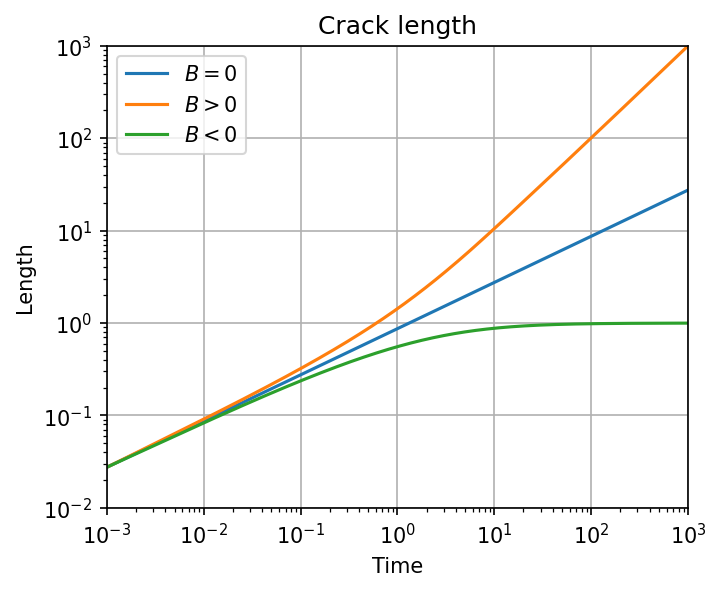

In [335]:
plt.figure(figsize = (5,4),dpi = 150)
plt.plot(sol0['time'],sol0['length'], label = '$B = 0$')
plt.plot(sol1['time'],sol1['length'], label = '$B > 0$')
plt.plot(sol1_['time'],sol1_['length'], label = '$B < 0$')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-2), 10**3])
plt.legend()
plt.title('Crack length')
plt.xlabel('Time')
plt.ylabel('Length')

#### Flux

Text(0, 0.5, 'Flux')

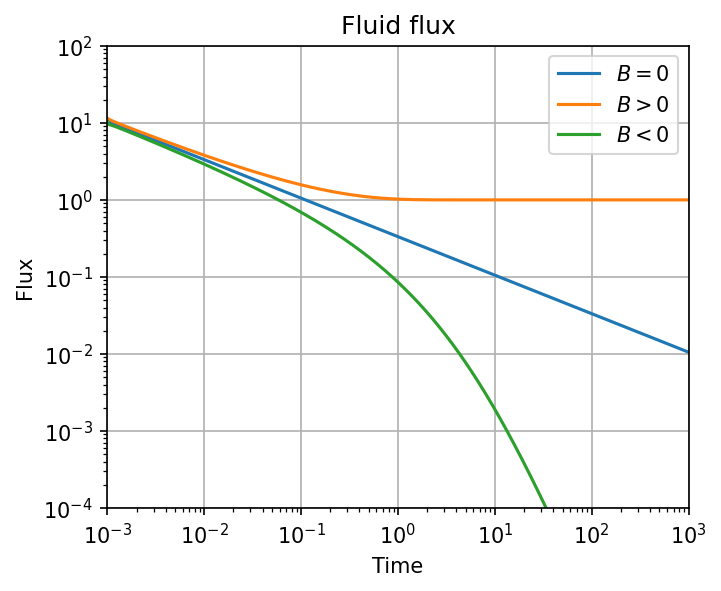

In [138]:
plt.figure(figsize = (5,4),dpi = 150)
plt.plot(sol0['time'],sol0['flux'], label = '$B = 0$')
plt.plot(sol1['time'],sol1['flux'], label = '$B > 0$')
plt.plot(sol1_['time'],sol1_['flux'], label = '$B < 0$')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-4), 10**2])
plt.legend()
plt.title('Fluid flux')
plt.xlabel('Time')
plt.ylabel('Flux')

#### Compare to Kanin's solution

In [340]:
# 0 - time, 1 - length, 2 - max opening, 8 - flux
k1 = np.load('kanin1.npy')
k1_profiles = np.load('kanin_profiles1.npy')
k0 = np.load('kanin0.npy')
k0_profiles = np.load('kanin_profiles0.npy')
k_1 = np.load('kanin-1.npy')
k_1_profiles = np.load('kanin_profiles-1.npy')


num_spatial = 101
spatial_mesh = np.cos(np.pi / num_spatial * (np.arange(1, num_spatial + 1) - 0.5))
spatial_mesh[0], spatial_mesh[-1] = 1, -1
spatial_mesh = spatial_mesh[::-1] * 0.5 + 0.5
spatial_mesh = 0.5 * (spatial_mesh[1:] + spatial_mesh[:-1])

Text(0, 0.5, 'Flux')

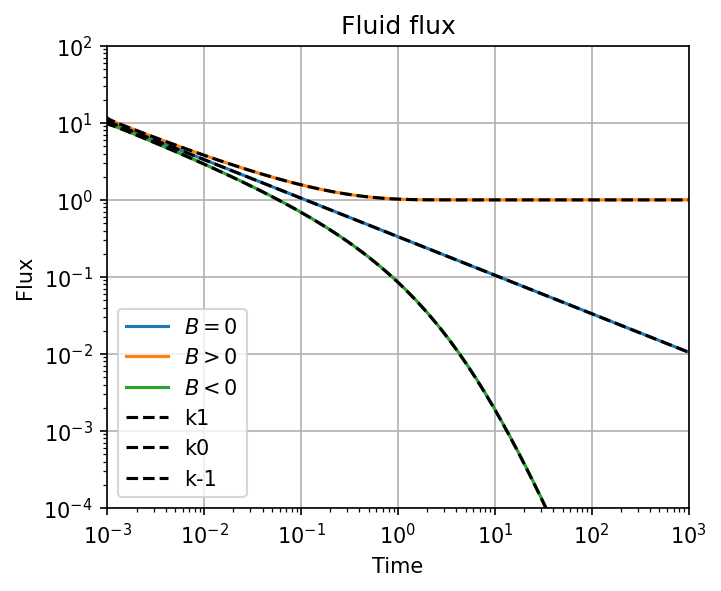

In [341]:
plt.figure(figsize = (5,4),dpi = 150)
plt.plot(sol0['time'],sol0['flux'], label = '$B = 0$')
plt.plot(sol1['time'],sol1['flux'], label = '$B > 0$')
plt.plot(sol1_['time'],sol1_['flux'], label = '$B < 0$')

plt.plot(k1[0],k1[8],"--", c = 'black', label = 'k1')
plt.plot(k0[0],k0[8],"--", c = 'black', label = 'k0')
plt.plot(k_1[0],k_1[8],"--", c = 'black', label = 'k-1')

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-4), 10**2])
plt.legend()
plt.title('Fluid flux')
plt.xlabel('Time')
plt.ylabel('Flux')

Text(0, 0.5, 'Length')

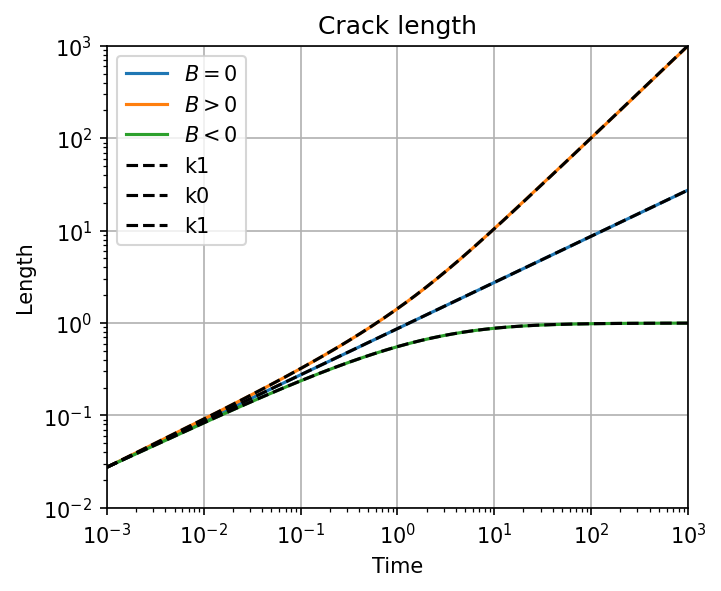

In [342]:
plt.figure(figsize = (5,4), dpi = 150)
plt.plot(sol0['time'],sol0['length'], label = '$B = 0$')
plt.plot(sol1['time'],sol1['length'], label = '$B > 0$')
plt.plot(sol1_['time'],sol1_['length'], label = '$B < 0$')

plt.plot(k1[0],k1[1],"--", c = 'black', label = 'k1')
plt.plot(k0[0],k0[1],"--", c = 'black', label = 'k0')
plt.plot(k_1[0],k_1[1],"--", c = 'black', label = 'k1')

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-2), 10**3])
plt.legend()
plt.title('Crack length')
plt.xlabel('Time')
plt.ylabel('Length')

Text(0, 0.5, 'Opening')

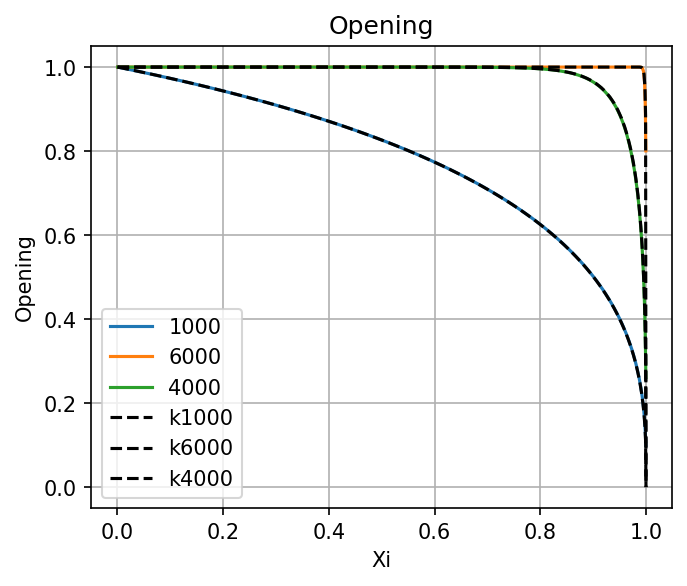

In [348]:
plt.figure(figsize = (5,4), dpi = 150)
plt.plot(sol1['x'],sol1['opening'][1000], label = '1000')
plt.plot(sol1['x'],sol1['opening'][6000], label = '6000')
plt.plot(sol1['x'],sol1['opening'][4000], label = '4000')

plt.plot(spatial_mesh,k1_profiles[1000],"--", c = 'black', label = 'k1000')
plt.plot(spatial_mesh,k1_profiles[6000],"--", c = 'black', label = 'k6000')
plt.plot(spatial_mesh,k1_profiles[4000],"--", c = 'black', label = 'k4000')
plt.grid()
plt.legend()
plt.title('Opening')
plt.xlabel('Xi')
plt.ylabel('Opening')

Text(0, 0.5, 'Opening')

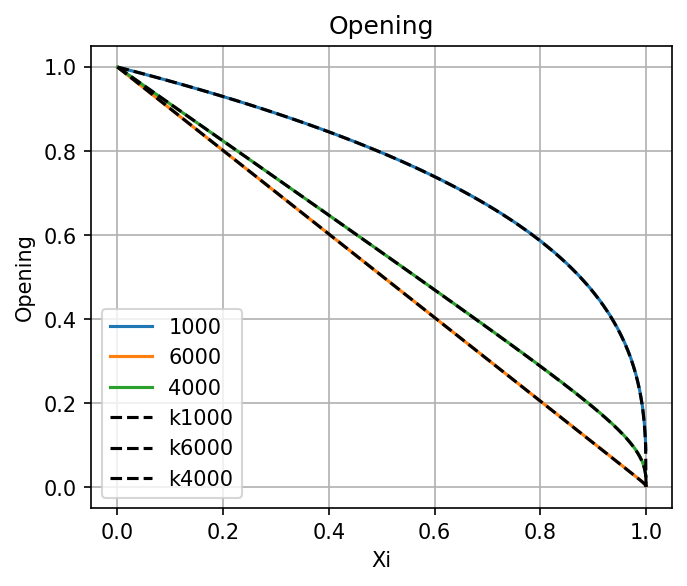

In [351]:
plt.figure(figsize = (5,4), dpi = 150)
plt.plot(sol1_['x'],sol1_['opening'][1000], label = '1000')
plt.plot(sol1_['x'],sol1_['opening'][6000], label = '6000')
plt.plot(sol1_['x'],sol1_['opening'][4000], label = '4000')

plt.plot(spatial_mesh,k_1_profiles[1000],"--", c = 'black', label = 'k1000')
plt.plot(spatial_mesh,k_1_profiles[6000],"--", c = 'black', label = 'k6000')
plt.plot(spatial_mesh,k_1_profiles[4000],"--", c = 'black', label = 'k4000')
plt.grid()
plt.legend()
plt.title('Opening')
plt.xlabel('Xi')
plt.ylabel('Opening')

#### Error of solution

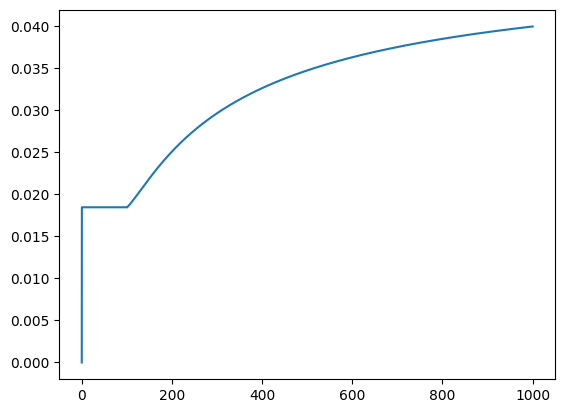

In [139]:
g_teor = 0.86998*np.sqrt(sol0['time'])
error = np.abs(g_teor - sol0['length'])/sol0['length']
plt.plot(sol0['time'], error*100)

### Adding T

Text(0, 0.5, 'Length')

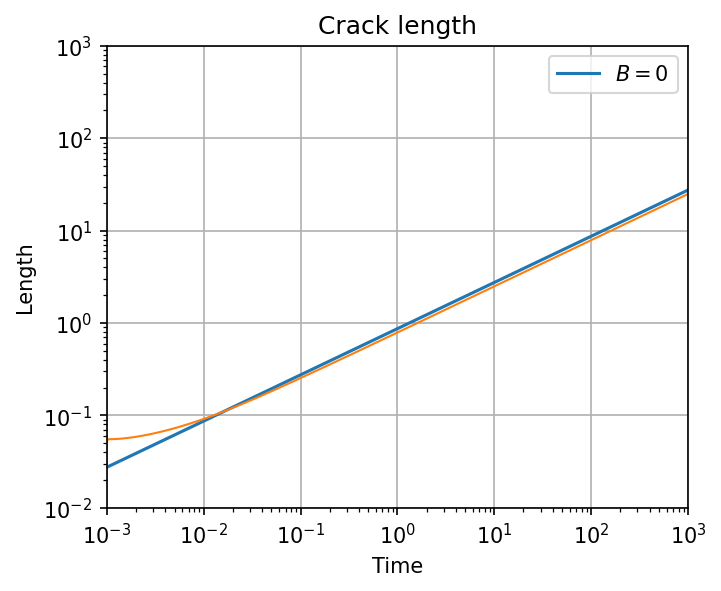

In [54]:
plt.figure(figsize = (5,4),dpi = 150)
plt.plot(sol0['time'],sol0['length'], label = '$B = 0$')
# plt.plot(sol1['time'],sol1['length'], label = '$B > 0$')
# plt.plot(sol1_['time'],sol1_['length'], label = '$B < 0$')

# plt.plot(sol1T['time'],sol1T['length'], "-", c = 'black', label = '$T, B > 0$')
# plt.plot(sol0T['time'],sol0T['length'], "--", c = 'black', label = '$T, B = 0$')
# plt.plot(sol1_T['time'],sol1_T['length'], "--", c = 'black', label = '$T, B < 0$')
# plt.plot(t[:len(g)], g, "--", c = 'black', label = '$T, B < 0$')

plt.plot(solution['time'], solution['length'], linewidth = 1)

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-2), 10**3])
plt.legend()
plt.title('Crack length')
plt.xlabel('Time')
plt.ylabel('Length')

Text(0, 0.5, 'Flux')

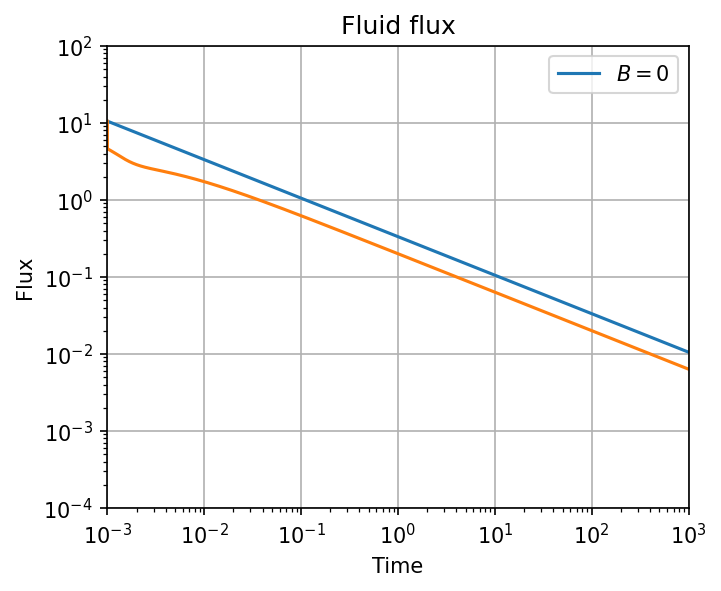

In [61]:
plt.figure(figsize = (5,4),dpi = 150)
plt.plot(sol0['time'],sol0['flux'], label = '$B = 0$')
# plt.plot(sol1['time'],sol1['flux'], label = '$B > 0$')
# plt.plot(sol1_['time'],sol1_['flux'], label = '$B < 0$')

# plt.plot(sol1T['time'],sol1T['flux'], "--", c = 'black', label = '$T, B > 0$')
# plt.plot(sol0T['time'],sol0T['flux'], "--", c = 'black', label = '$T, B = 0$')
# plt.plot(sol1_T['time'],sol1_T['flux'], "--", c = 'black', label = '$T, B < 0$')

# plt.plot(t[:len(psi)], psi)

plt.plot(solution['time'], solution['flux'])

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-4), 10**2])
plt.legend()
plt.title('Fluid flux')
plt.xlabel('Time')
plt.ylabel('Flux')

Text(0, 0.5, 'Opening')

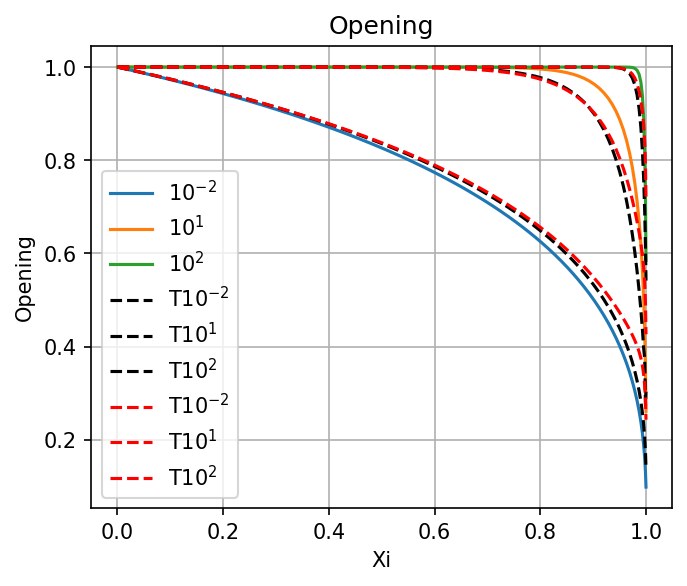

In [150]:
plt.figure(figsize = (5,4), dpi = 150)
plt.plot(sol1['x'],sol1['opening'][np.where(np.isclose(sol1['time'], 10**(-2)))][0], label = '$10^{-2}$')
plt.plot(sol1['x'],sol1['opening'][np.where(np.isclose(sol1['time'], 10**(1)))][0], label = '$10^{1}$')
plt.plot(sol1['x'],sol1['opening'][np.where(np.isclose(sol1['time'], 10**(2)))][0], label = '$10^{2}$')

plt.plot(sol1T['x'],sol1T['opening'][np.where(np.isclose(sol1T['time'], 10**(-2)))][0],"--", c = 'black', label ='T$10^{-2}$')
plt.plot(sol1T['x'],sol1T['opening'][np.where(np.isclose(sol1T['time'], 10**(1)))][0],"--", c = 'black', label = 'T$10^{1}$')
plt.plot(sol1T['x'],sol1T['opening'][np.where(np.isclose(sol1T['time'], 10**(2)))][0],"--", c = 'black', label = 'T$10^{2}$')

plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(-2)))][0],"--", c = 'red', label ='T$10^{-2}$')
plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(1)))][0],"--", c = 'red', label = 'T$10^{1}$')
plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(2)))][0],"--", c = 'red', label = 'T$10^{2}$')

plt.grid()
plt.legend()
plt.title('Opening')
plt.xlabel('Xi')
plt.ylabel('Opening')

Text(0, 0.5, 'Opening')

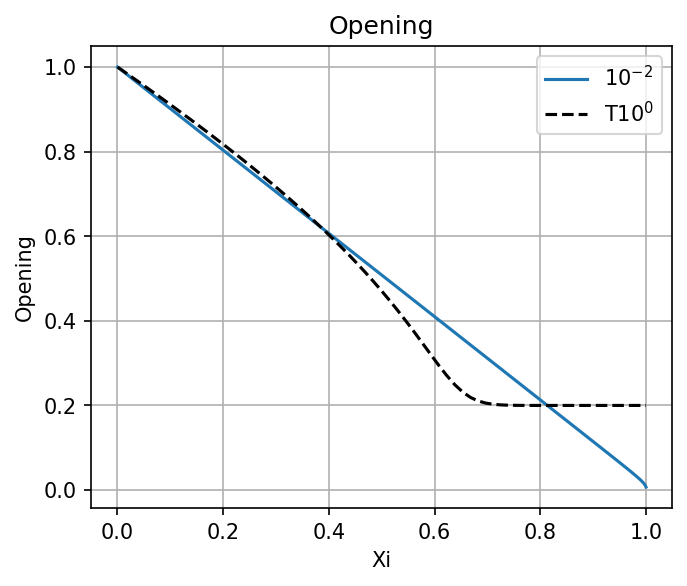

In [166]:
plt.figure(figsize = (5,4), dpi = 150)
plt.plot(sol1_['x'],sol1_['opening'][np.where(np.isclose(sol1_['time'], 10**(2)))][0], label = '$10^{-2}$')
# plt.plot(sol1['x'],sol1['opening'][np.where(np.isclose(sol1['time'], 10**(1)))][0], label = '$10^{1}$')
# plt.plot(sol1['x'],sol1['opening'][np.where(np.isclose(sol1['time'], 10**(2)))][0], label = '$10^{2}$')

# plt.plot(xi, W[np.where(np.isclose(t, 10**(-0.8)))][0],"--", c = 'black', label ='T$10^{-2}$')
plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(0.15)))][0],"--", c = 'black', label = 'T$10^{0}$')
# plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(2)))][0],"--", c = 'black', label = 'T$10^{2}$')
plt.grid()
plt.legend()
plt.title('Opening')
plt.xlabel('Xi')
plt.ylabel('Opening')

Text(0, 0.5, 'Opening')

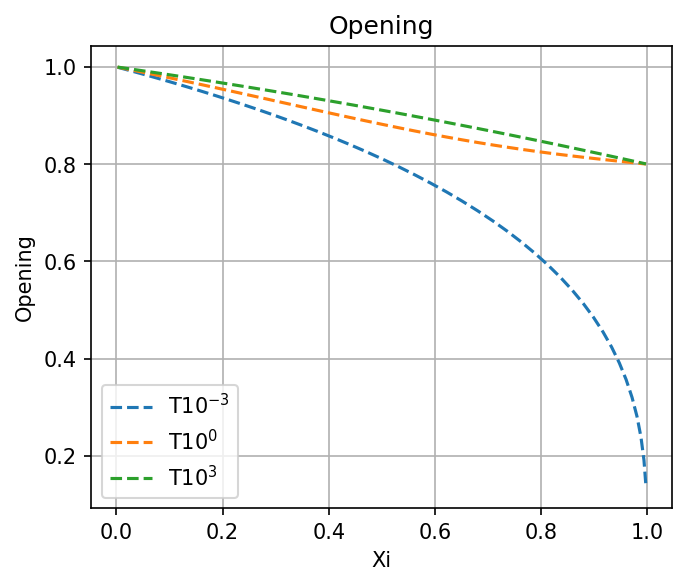

In [70]:
plt.figure(figsize = (5,4), dpi = 150)
# plt.plot(sol0['x'],sol0['opening'][np.where(np.isclose(sol0['time'], 10**(0)))][0], label = '$10^{-2}$')
# plt.plot(sol0['x'],sol0['opening'][np.where(np.isclose(sol0['time'], 10**(1)))][0], label = '$10^{1}$')
# plt.plot(sol0['x'],sol0['opening'][np.where(np.isclose(sol0['time'], 10**(3)))][0], label = '$10^{2}$')

# plt.plot(xi, W[np.where(np.isclose(t, 10**(-0.8)))][0],"--", c = 'black', label ='T$10^{-2}$')
plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(-3)))][0],"--", label = 'T$10^{-3}$')
plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(-2.9)))][0],"--", label = 'T$10^{0}$')
plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(3)))][0],"--", label = 'T$10^{3}$')
plt.grid()
plt.legend()
plt.title('Opening')
plt.xlabel('Xi')
plt.ylabel('Opening')

In [136]:
sol0['opening']

array([0.99984246, 0.99956234, 0.99914206, 0.99858149, 0.99788048,
       0.99703882, 0.99605626, 0.99493251, 0.99366727, 0.99226015,
       0.99071076, 0.98901866, 0.98718336, 0.98520435, 0.98308108,
       0.98081295, 0.97839933, 0.97583956, 0.97313295, 0.97027875,
       0.96727621, 0.96412452, 0.96082285, 0.95737033, 0.95376608,
       0.95000915, 0.9460986 , 0.94203344, 0.93781265, 0.93343518,
       0.92889997, 0.92420591, 0.91935187, 0.91433669, 0.90915919,
       0.90381815, 0.89831235, 0.8926405 , 0.88680132, 0.88079347,
       0.87461561, 0.86826635, 0.86174427, 0.85504793, 0.84817584,
       0.84112649, 0.83389831, 0.82648971, 0.81889906, 0.81112465,
       0.80316475, 0.79501757, 0.78668126, 0.77815389, 0.76943348,
       0.76051796, 0.75140518, 0.7420929 , 0.73257875, 0.72286029,
       0.71293491, 0.70279988, 0.69245231, 0.68188915, 0.67110714,
       0.66010279, 0.64887241, 0.63741201, 0.6257173 , 0.61378365,
       0.60160607, 0.58917912, 0.57649685, 0.5635528 , 0.55033

In [390]:
solution['time'][2800]

0.1